# PREDICTING RENEWABLE ENERGY OUTPUT AND CONSUMPTION (6+3)
by Héctor Ramírez

<hr>

# Conclusions & thoughts
<hr>
<ul> 
    <li> Data prepartion is exactly the same as in the other notebook (jump to predictions).
    <li> Results are similar as in the other notebook. Sadly, the t+2 and t+3 hours are poorly predicted. <br><br>
        I would say it is because I am dropping the 'Demanda (W)' (t), (t+1) and (t+2) columns as they are my target. However, the (t) might be useful for predicting (t+1) and (t+2), and so forth.
</ul>
<hr>
<hr>

## Data Preparation

Very similar to the Google Colab file.

In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
warnings.filterwarnings('ignore')

In [2]:
# My files locally
files_path = "/Users/hramirez/GitHub/Renewable_Energy/files/"

Meteo = pd.read_csv(files_path + "Meteo.csv", parse_dates=[['Date', 'Time']])
datos_solar = pd.read_excel(files_path + "Datos_solar_y_demanda_residencial.xlsx")
# Meteo.head()

In [3]:
# datos_solar.head()

In [4]:
# Transform times

def round_to_5min(t):
    delta = datetime.timedelta(minutes=t.minute % 5,
                               seconds=t.second,
                               microseconds=t.microsecond)
    t -= delta
    if delta > datetime.timedelta(0):
        t += datetime.timedelta(minutes=5)
    return t


Meteo['DateRound'] = Meteo["Date_Time"].dt.round("5min")
datos_solar['DateRound'] = datos_solar['Date'].dt.round("5min")

Meteo['Hour'] = Meteo['DateRound'].dt.hour
Meteo['Day'] = Meteo['DateRound'].dt.dayofyear
# Meteo.head()

In [5]:
# datos_solar.head()

In [6]:
# Clean Meteo Frame from characters and columns that do not give information in this case: UV, Solar and Wind**

def clean(x):
    try:
        return x.str.replace(r"[a-zA-Z\%\/²]", '')
    except:
        return x


Meteo = Meteo.apply(lambda x: clean(x))
Meteo = Meteo.drop(columns=['UV', 'Solar', 'Wind'])
# Meteo.head()

In [7]:
Meteo.Temperature = pd.to_numeric(Meteo.Temperature)

In [8]:
# Select relevant features for the final Meteo dataframe
# From solar dataframe selection only 'Demanda (W)'

list_features = ['Date_Time', 'Temperature', 'Dew Point', 'Humidity', 'Speed', 'Gust',
                 'Pressure', 'Precip. Rate.', 'Precip. Accum.', 'DateRound', 'Hour',
                 'Day']

Meteo_features = Meteo[list_features]
solar_demanda = datos_solar[['DateRound', 'Demanda (W)']]

# Merge both pandas based on datetime

df_demanda = pd.merge(Meteo_features, solar_demanda, on='DateRound')
# remove date from df
del df_demanda['DateRound']
# df_demanda.head()

In [9]:
cols = df_demanda.columns.drop(['Date_Time', 'Hour', 'Day'])
df_demanda[cols] = df_demanda[cols].apply(pd.to_numeric)

'''for i in range(len(cols)):
    df_demanda.plot(x='Date_Time', y=df_demanda[cols].columns[[i]], figsize=(15,5))'''

"for i in range(len(cols)):\n    df_demanda.plot(x='Date_Time', y=df_demanda[cols].columns[[i]], figsize=(15,5))"

## Predictions

<hr>
<ul>
    <li> Only two features are kept: 'Temperature' and 'Demanda (W)' as the results of including the rest are only minimally improved.</li>
    <li> These features are transformed with the <code>series_to_supervised()</code> function, <i>i.e.</i>, new features are engineered by lagging 'Temperature' and 'Demanda (W)'.</li>
    <li> In this notebook <b>we focus on 6+3 hours</b>: creating three lagged features for variable and predicting the next three ones.</li>
    <li> We split the data to train (80%) and test (20%) sets and shuffle them given that this improves the results. However a couple of notes are in order as mentioned <a href='https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/'> here</a>:</li>
        <ul>
            <li> <i>We do not want to shuffle inputs because all samples are sequential.</i></li>
            <li> <i>By default, the samples within an epoch are shuffled prior to being exposed to the network. Again, this is undesirable for the LSTM because we want the network to build up state as it learns across the sequence of observations</i>.</li>
        <\ul>
</ul>
<hr>

In [10]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as MSE, r2_score
from pandas import DataFrame, concat
from numpy import concatenate
from sklearn.utils import shuffle
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import EarlyStopping
import xgboost as xgb

Using TensorFlow backend.


<hr>

### Transform

<ul>
    <li> All columns are scaled and shifted according to the <code>series_to_supervised()</code> function. The shifted target column will also be a feature!
    <li> This dataframe is concatenated to the target.
</ul>
<hr>

In [11]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = [], []
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


# values = df_demanda.drop(['Date_Time', 'Day'], axis=1).values
values = df_demanda[['Temperature', 'Demanda (W)']].values

n_features = values.shape[1]
n_hours = 6
n_out = 3

# frame as supervised learning
lagged = series_to_supervised(values[:, :], n_hours, n_out, True)  # .reset_index(drop=True)

# put target columns at the end
sort = lagged.iloc[:, n_hours*n_features:][sorted(lagged.columns[n_hours*n_features:])]
lagged = pd.concat([lagged.iloc[:, :n_hours*n_features], sort], axis=1).dropna()

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(lagged.values)
reframed = pd.DataFrame(scaled, columns=lagged.columns)

print(reframed.shape)
reframed.head(10)

(8222, 18)


,var1(t-6),var2(t-6),var1(t-5),var2(t-5),var1(t-4),var2(t-4),var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t),var1(t+1),var1(t+2),var2(t),var2(t+1),var2(t+2)
0,0.115385,0.039287,0.081585,0.047654,0.081585,0.165151,0.058275,0.250637,0.066434,0.245726,0.058275,0.239724,0.068765,0.068765,0.079254,0.242270,0.272645,0.385959
1,0.081585,0.047654,0.081585,0.165151,0.058275,0.250637,0.066434,0.245726,0.058275,0.239724,0.068765,0.242270,0.068765,0.079254,0.123543,0.272645,0.385959,0.182066
2,0.081585,0.165151,0.058275,0.250637,0.066434,0.245726,0.058275,0.239724,0.068765,0.242270,0.068765,0.272645,0.079254,0.123543,0.268065,0.385959,0.182066,0.292834
3,0.058275,0.250637,0.066434,0.245726,0.058275,0.239724,0.068765,0.242270,0.068765,0.272645,0.079254,0.385959,0.123543,0.268065,0.389277,0.182066,0.292834,0.267370
4,0.066434,0.245726,0.058275,0.239724,0.068765,0.242270,0.068765,0.272645,0.079254,0.385959,0.123543,0.182066,0.268065,0.389277,0.351981,0.292834,0.267370,0.223354
5,0.058275,0.239724,0.068765,0.242270,0.068765,0.272645,0.079254,0.385959,0.123543,0.182066,0.268065,0.292834,0.389277,0.351981,0.388112,0.267370,0.223354,0.030920
6,0.068765,0.242270,0.068765,0.272645,0.079254,0.385959,0.123543,0.182066,0.268065,0.292834,0.389277,0.267370,0.351981,0.388112,0.420746,0.223354,0.030920,0.077846
7,0.068765,0.272645,0.079254,0.385959,0.123543,0.182066,0.268065,0.292834,0.389277,0.267370,0.351981,0.223354,0.388112,0.420746,0.431235,0.030920,0.077846,0.042561
8,0.079254,0.385959,0.123543,0.182066,0.268065,0.292834,0.389277,0.267370,0.351981,0.223354,0.388112,0.030920,0.420746,0.431235,0.389277,0.077846,0.042561,0.046017
9,0.123543,0.182066,0.268065,0.292834,0.389277,0.267370,0.351981,0.223354,0.388112,0.030920,0.420746,0.077846,0.431235,0.389277,0.276224,0.042561,0.046017,0.170062


<hr>

### Split in train and test sets
<ul>
    <li> The data are shuffled.
    <li> We take 80% of the dataset for training.
    <li> X_train and _test sets contain only lagged data&mdash;no var(t).
</ul>
<hr>

In [12]:
shuffled_vals = True

# shuffle data
idx = np.arange(reframed.shape[0])
np.random.shuffle(idx)

if shuffled_vals:
    values = reframed.values[idx]
else: values = reframed.values

# split into train and test sets (80%)
n_train_hours = int(reframed.shape[0] * 0.8)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# Total set of (lagged) features
n_obs = n_hours * n_features

# split into input and outputs
X_train, y_train = train[:, :n_obs], train[:, -n_out:]
X_test, y_test = test[:, :n_obs], test[:, -n_out:]
print(X_train.shape, y_train.shape)

# reshape input to be 3D [samples, timesteps, features]
X_train_in = X_train.reshape((X_train.shape[0], n_hours, n_features))#X_train.shape[1]))
X_test_in = X_test.reshape((X_test.shape[0], n_hours, n_features))#X_test.shape[1]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(6577, 12) (6577, 3)
(6577, 12) (6577, 3) (1645, 12) (1645, 3)


<hr>

### LSTM Net

Test loss: 0.0732939193993354
Test mean squared error: 0.015292313881218433


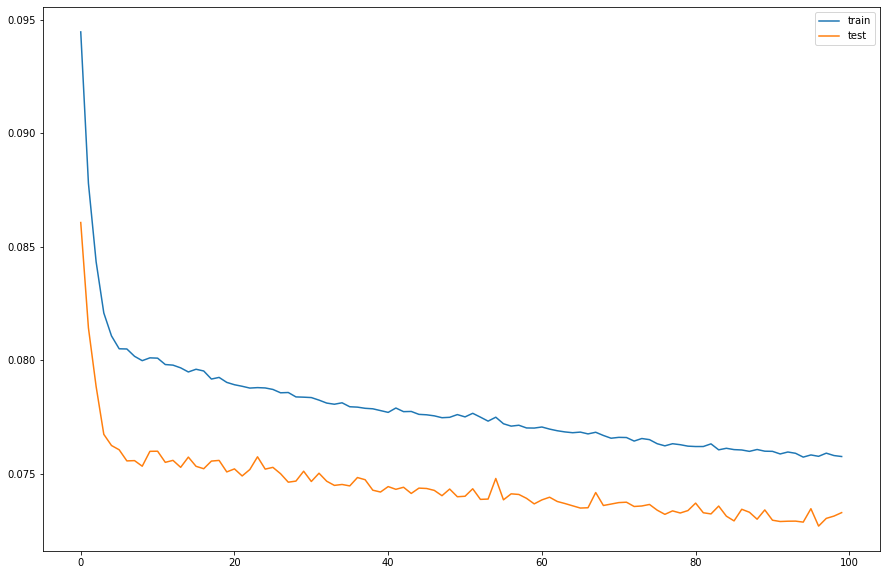

In [13]:
def fit_network(n_neurons=50, n_outputs=n_out,
                optimizer='adam', batch_size=72, epochs=100, verbosity=2, shuffled=False):
    
    # design network
    model = Sequential()
    model.add(LSTM(n_neurons, input_shape=(X_train_in.shape[1], X_train_in.shape[2])))
    model.add(Dense(n_outputs))
    model.compile(loss='mae', optimizer=optimizer, metrics=['mse'])

    # Run network
    history = model.fit(X_train_in, y_train, epochs=100, batch_size=batch_size, 
                        callbacks=[EarlyStopping(monitor='val_loss', patience=10)],
                        #validation_split=0.1, 
                        validation_data=(X_test_in, y_test),
                        verbose=verbosity, shuffle=shuffled)
    
    return (model, history)

model, history = fit_network(shuffled=True, verbosity=0)

loss, mse = model.evaluate(X_test_in, y_test, verbose=0)
print('Test loss:', loss)
print('Test mean squared error:', mse)

# plot history
plt.figure(figsize=(15,10))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

<hr>

### Predictions
<ul>
    <li> y_pred_out and y_test are concatenated to a full set of features&mdash;var(t-1), in this case&mdash;in order to perform the inverse scaling only.
    <li> Then we calculate the RMSE, model accuracy and the <a href='https://en.wikipedia.org/wiki/Mean_directional_accuracy'>mean directional accuracy</a>.
</ul>
<hr>

In [14]:
y_pred_out = model.predict(X_test_in)

#======================================================= inverting
def inverting(series, ls=-1):
    x = scaler.inverse_transform(concatenate((test[:, :-n_out], series), axis=1))[:, -n_out:]
    return x

y_pred = inverting(y_pred_out)
y_inv = inverting(y_test)
#=======================================================


#======================================================= metrics
for i in range(n_out):

    print('t+%d:' % (i+1))
    # calculate RMSE
    rmse = sqrt(MSE(y_inv[:,i], y_pred[:,i]))
    print('Test RMSE: %.3f' % (rmse))

    # calculate model accuracy
    LSTM_accuracy = r2_score(y_inv, y_pred)
    print('Model accuracy: {:.3f}'.format(LSTM_accuracy))

    # calculate mean directional accuracy
    def mda(actual: np.ndarray, predicted: np.ndarray):
        """ Mean Directional Accuracy """
        return np.mean((np.sign(actual[1:] - actual[:-1]) 
                        == np.sign(predicted[1:] - predicted[:-1])).astype(int))

    print('Model Mean Directional accuracy: {:.3f}'.format(mda(y_inv[:,i], y_pred[:,i])))
    print('\n')

t+1:
Test RMSE: 518.153
Model accuracy: 0.210
Model Mean Directional accuracy: 0.762


t+2:
Test RMSE: 703.097
Model accuracy: 0.210
Model Mean Directional accuracy: 0.693


t+3:
Test RMSE: 789.899
Model accuracy: 0.210
Model Mean Directional accuracy: 0.643




<hr>
The following plots show:
<ol>
  <li>The full y_test set and the predictions, ordered in time (remember that this is a random-shuffling sample).
  <li> The same y_test and predictions of only the last 150 data points.
  <li> The full dataset and its prediction for only the first (ordered) pnts=800 data points. This one should be taken carefully as points used for training the model were used for predicting.
</ol>
<hr>

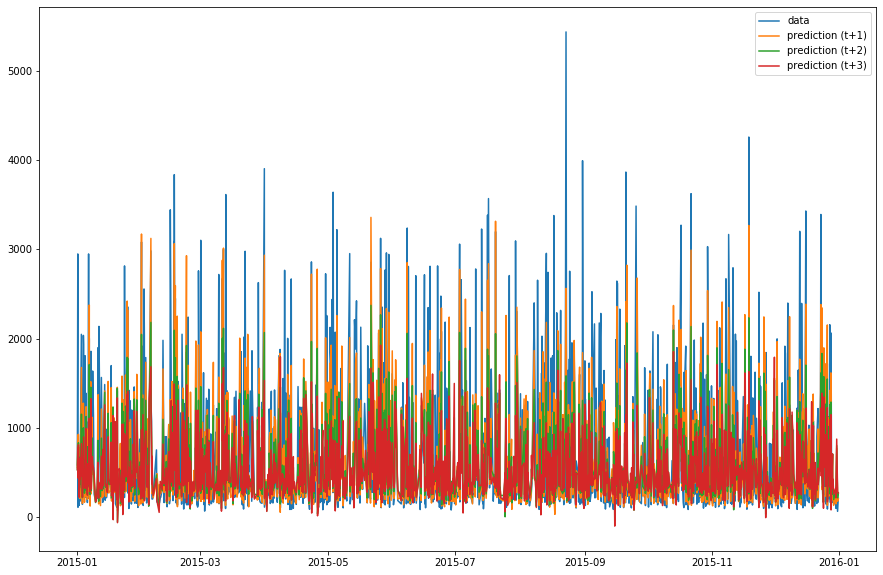

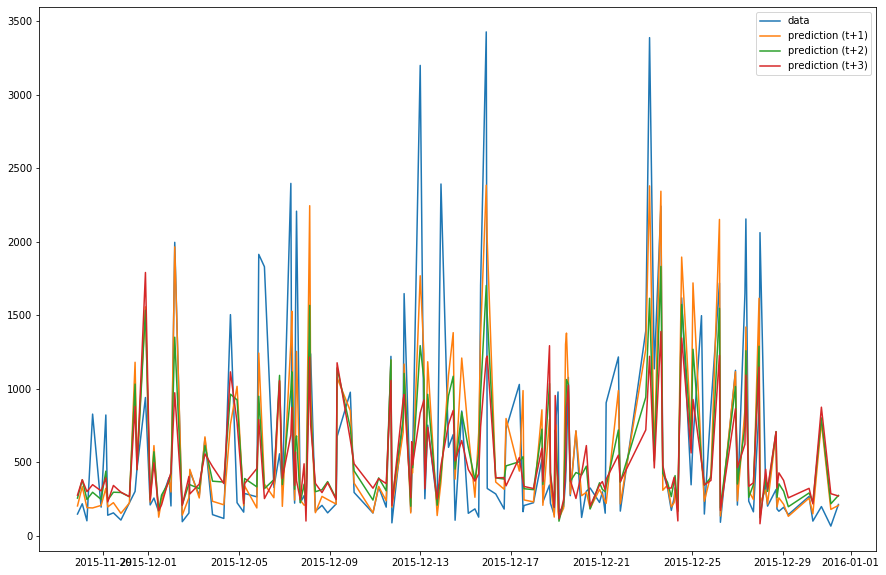

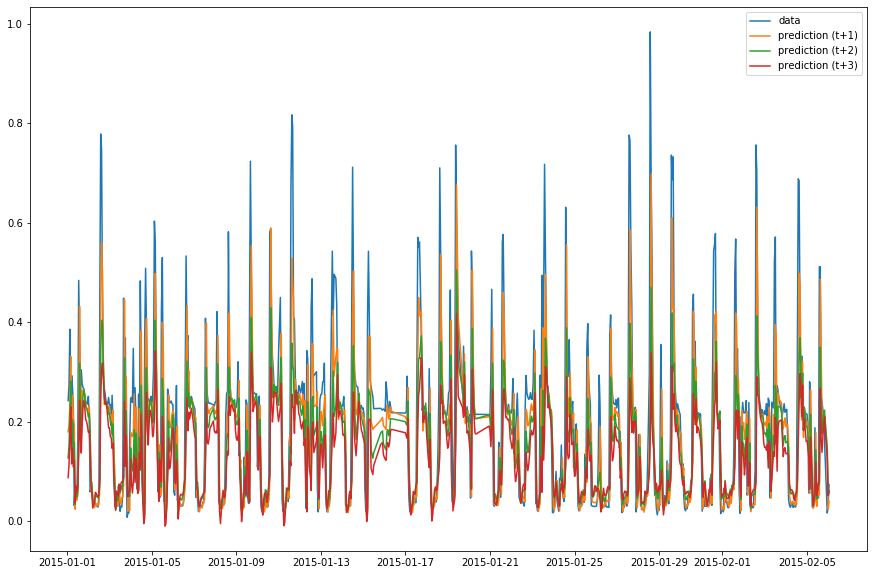

In [15]:
#======================================================= plot predictions

hours_df = df_demanda.Date_Time[idx].iloc[n_train_hours:].sort_values()

plt.figure(figsize=(15, 10))
plt.plot(hours_df, y_inv[:,0], label='data')
for i in range(n_out):
    plt.plot(hours_df, y_pred[:,i], label='prediction (t+{:})'.format(i+1))
plt.legend()
# plt.savefig('predvsdata.pdf')

plt.figure(figsize=(15, 10))
plt.plot(hours_df[-150:], y_inv[-150:,0], label='data')
for i in range(n_out):
    plt.plot(hours_df[-150:], y_pred[-150:, i], label='prediction (t+{:})'.format(i+1))
plt.legend()

rf = reframed.iloc[:, :n_obs].values
rf_rs = rf.reshape((rf.shape[0], n_hours, n_features))
y_pred_full = model.predict(rf_rs)
#
pnts = 800
plt.figure(figsize=(15, 10))
plt.plot(df_demanda.Date_Time[:pnts], reframed.iloc[:pnts, -n_out], label='data')
for i in range(n_out):
    plt.plot(df_demanda.Date_Time[:pnts], y_pred_full[:pnts,i], label='prediction (t+{:})'.format(i+1))
plt.legend()

<hr>
Next, we <b>repeat the experiment 30 times</b> to obtain statistics of the metrics.
<hr>

100%|██████████| 31/31 [20:23<00:00, 39.47s/it]


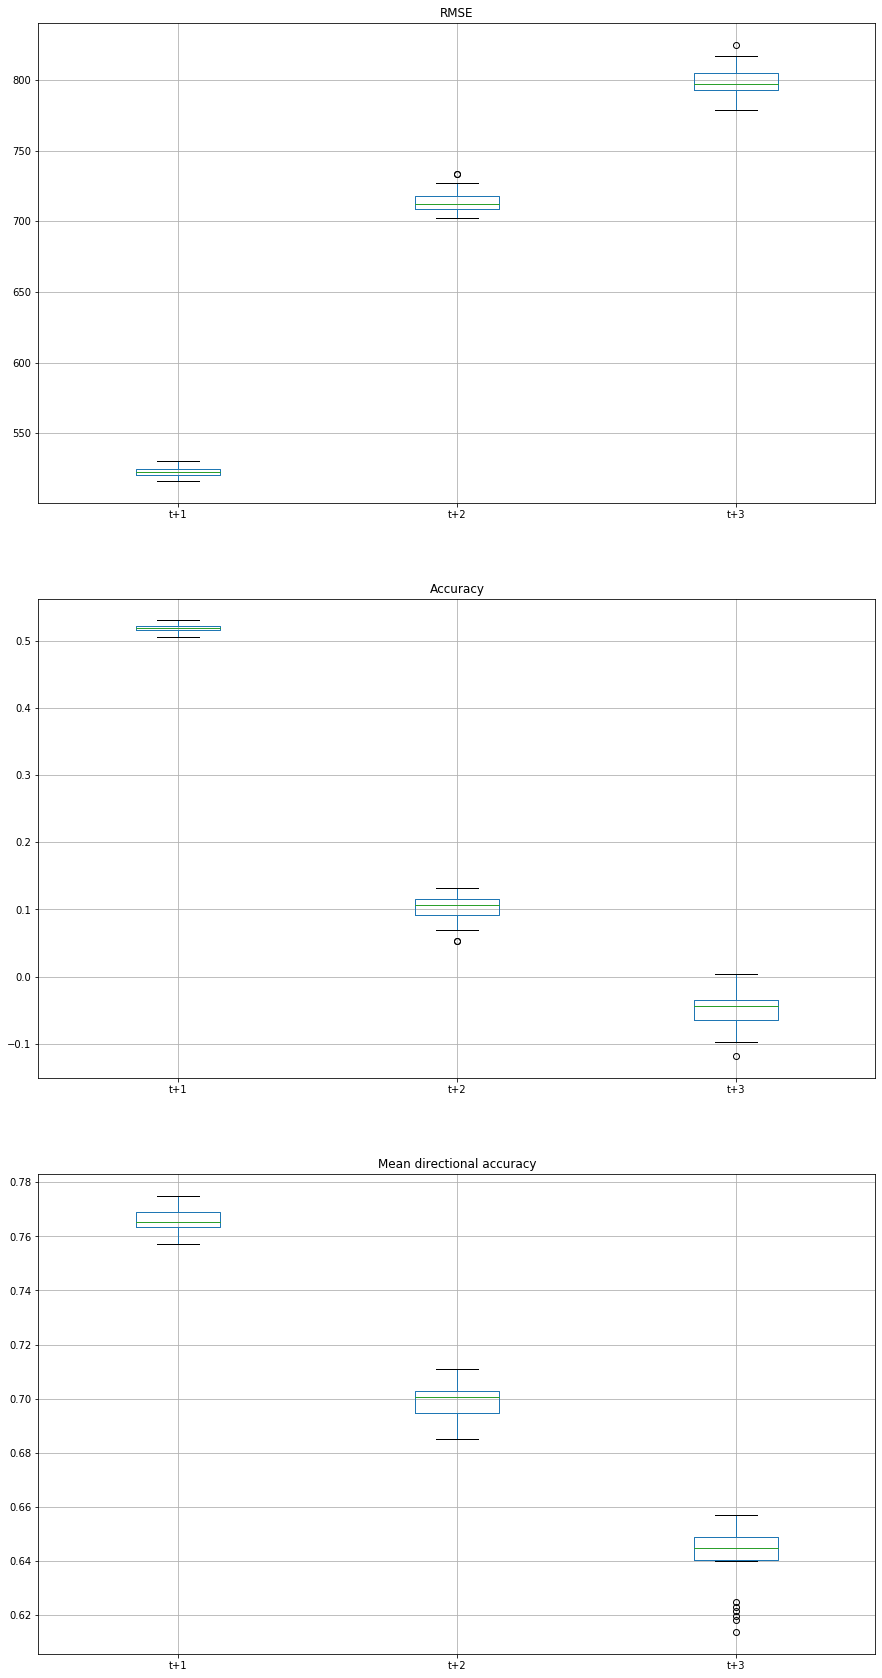

In [16]:
def lstm_net(X_train_in, y_train, X_test_in, y_test, X_test):
    
    model, history = fit_network(verbosity=0, shuffled=True)
    y_pred_out = model.predict(X_test_in)

    # invert scaling for forecast and actual
    y_pred = inverting(y_pred_out)
    y_inv = inverting(y_test)

    # metrics 
    rmse = [sqrt(MSE(y_inv[:,i], y_pred[:,i])) for i in range(n_out)] 
    LSTM_accuracy = [r2_score(y_inv[:,i], y_pred[:,i]) for i in range(n_out)]
    mean_da = [mda(y_inv[:,i], y_pred[:,i]) for i in range(n_out)]
    
    return (rmse, y_inv, y_pred, LSTM_accuracy, mean_da)

import time
from tqdm import tqdm
    
rmse_l, y_inv_l, y_pred_l, acc_l, mda_l = [], [], [], [], []
for i in tqdm(range(31)):
    tqdm._instances.clear()
    
    rmse, y_inv, y_pred, acc, mdacc = lstm_net(X_train_in, y_train, X_test_in, y_test, X_test)
    
    rmse_l.append(rmse)
    y_inv_l.append(y_inv)
    y_pred_l.append(y_pred)
    acc_l.append(acc)
    mda_l.append(mdacc)
    
'''# getting the index of the median rmse value and extract the predictions of this value
rsme_df = pd.DataFrame(rmse_l)
rsme_med = pd.DataFrame(rmse_l).median().values[0]
ind_med = rsme_df[rsme_df[0]==rsme_med].index.tolist()[0]
y_pred_lstm = y_pred_l[ind_med]'''

fig, ax = plt.subplots(3, 1, figsize=(15,30))
ax[0].set_title('RMSE')
ax[1].set_title('Accuracy')
ax[2].set_title('Mean directional accuracy')
pd.DataFrame(rmse_l, columns=['t+1', 't+2', 't+3']).boxplot(ax=ax[0])
pd.DataFrame(acc_l, columns=['t+1', 't+2', 't+3']).boxplot(ax=ax[1])
pd.DataFrame(mda_l, columns=['t+1', 't+2', 't+3']).boxplot(ax=ax[2])
# plt.savefig('RMSE.pdf')